## Requirements

In [5]:
!pip install kaggle

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday

In [7]:
sns.set(style='darkgrid')

## Dataset

Dataset found on Kaggle that has historical data about stocks from January 2000 until today: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating

In [8]:
# Download the dataset
!kaggle datasets download -d nelgiriyewithana/world-stock-prices-daily-updating

# Unzip the downloaded dataset
!unzip world-stock-prices-daily-updating.zip

# Load the dataset into a dataframe
df = pd.read_csv('World-Stock-Prices-Dataset.csv')

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating
License(s): other
 43% 5.00M/11.5M [00:00<00:00, 33.2MB/s]
100% 11.5M/11.5M [00:00<00:00, 53.8MB/s]
Archive:  world-stock-prices-daily-updating.zip
  inflating: World-Stock-Prices-Dataset.csv  


In [9]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country
0,2024-06-21 00:00:00-04:00,3.630000,3.649900,3.522500,3.610000,9216069.0,0.0,0.0,peloton,PTON,fitness,usa
1,2024-06-21 00:00:00-04:00,116.459999,116.879997,115.940002,116.339996,34400.0,0.0,0.0,adidas,ADDYY,apparel,germany
2,2024-06-21 00:00:00-04:00,4.370000,4.370000,4.230000,4.260000,37900.0,0.0,0.0,ubisoft,UBSFY,gaming,france
3,2024-06-21 00:00:00-04:00,62.180000,63.099998,62.180000,62.770000,28278100.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa
4,2024-06-21 00:00:00-04:00,683.260010,686.900024,678.099976,686.119995,4506400.0,0.0,0.0,netflix,NFLX,entertainment,usa


Another option to get the data directly...

In [10]:
#!pip install yfinance

#import datetime
#import yfinance as yf

#start_date = datetime.datetime(2000, 1, 1)
#end_date = datetime.datetime(2023, 6, 30)
#sp500_data = yf.Ticker('^GSPC')
#sp500_df = sp500_data.history(start=start_date, end=end_date)
#sp500_df['Close'].plot(title='S&P 500 Stock');

## Pre-Processing & EDA


### Data Pre-Processing

**Analyse Missing Values**

In [11]:
# Analysing missing values
def analyse_missing_values(dataframe):
    # Count total missing and sort it
    total = dataframe.isnull().sum().sort_values(ascending=False)

    # Calculate percentage
    percent = (dataframe.isnull().sum() / dataframe.isnull().count() * 100).sort_values(ascending=False)

    # Concatenate total and percent into a DataFrame
    missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

    # Exclude columns that do not have any missing values
    missing_data = missing_data[missing_data['Total Missing'] > 0]

    return missing_data

# Get the missing values data
missing_values_data = analyse_missing_values(df)

print(missing_values_data)

Empty DataFrame
Columns: [Total Missing, Percent]
Index: []


**Parsing Dates**

In [12]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

**Numerical Correction**

In [13]:
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

**Handle Missing Data**

In [14]:
df.dropna(inplace=True)

**Standardising Text**

In [15]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.lower()

**Remove Whitespaces**

In [16]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.strip()

### Exploratory Data Analysis

In [17]:
# Summary statistics for numerical columns
summary_statistics = df.describe()

# Count of unique values in categorical columns
unique_brands = df['Brand_Name'].nunique()
unique_tickers = df['Ticker'].nunique()
unique_industries = df['Industry_Tag'].nunique()
unique_countries = df['Country'].nunique()

# Convert dates to datetime for any time series analysis
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Earliest and latest date in the dataset to understand the time range
earliest_date = df['Date'].min()
latest_date = df['Date'].max()

summary_statistics, unique_brands, unique_tickers, unique_industries, unique_countries, earliest_date, latest_date

(                Open           High            Low          Close  \
 count  291400.000000  291400.000000  291400.000000  291400.000000   
 mean       70.024270      70.818879      69.209505      70.032739   
 std       135.651032     137.106563     134.100904     135.628261   
 min         0.196890       0.199922       0.192798       0.198861   
 25%        15.385577      15.600000      15.166831      15.385665   
 50%        33.554023      33.934348      33.159845      33.557243   
 75%        76.500162      77.286003      75.769380      76.543926   
 max      3445.580078    3463.070068    3370.000000    3427.610107   
 
              Volume      Dividends   Stock Splits  
 count  2.914000e+05  291400.000000  291400.000000  
 mean   2.325877e+07       0.003566       0.000759  
 std    8.778198e+07       0.069683       0.074848  
 min    0.000000e+00       0.000000       0.000000  
 25%    1.357600e+06       0.000000       0.000000  
 50%    4.607750e+06       0.000000       0.000000

### Graph Analysis

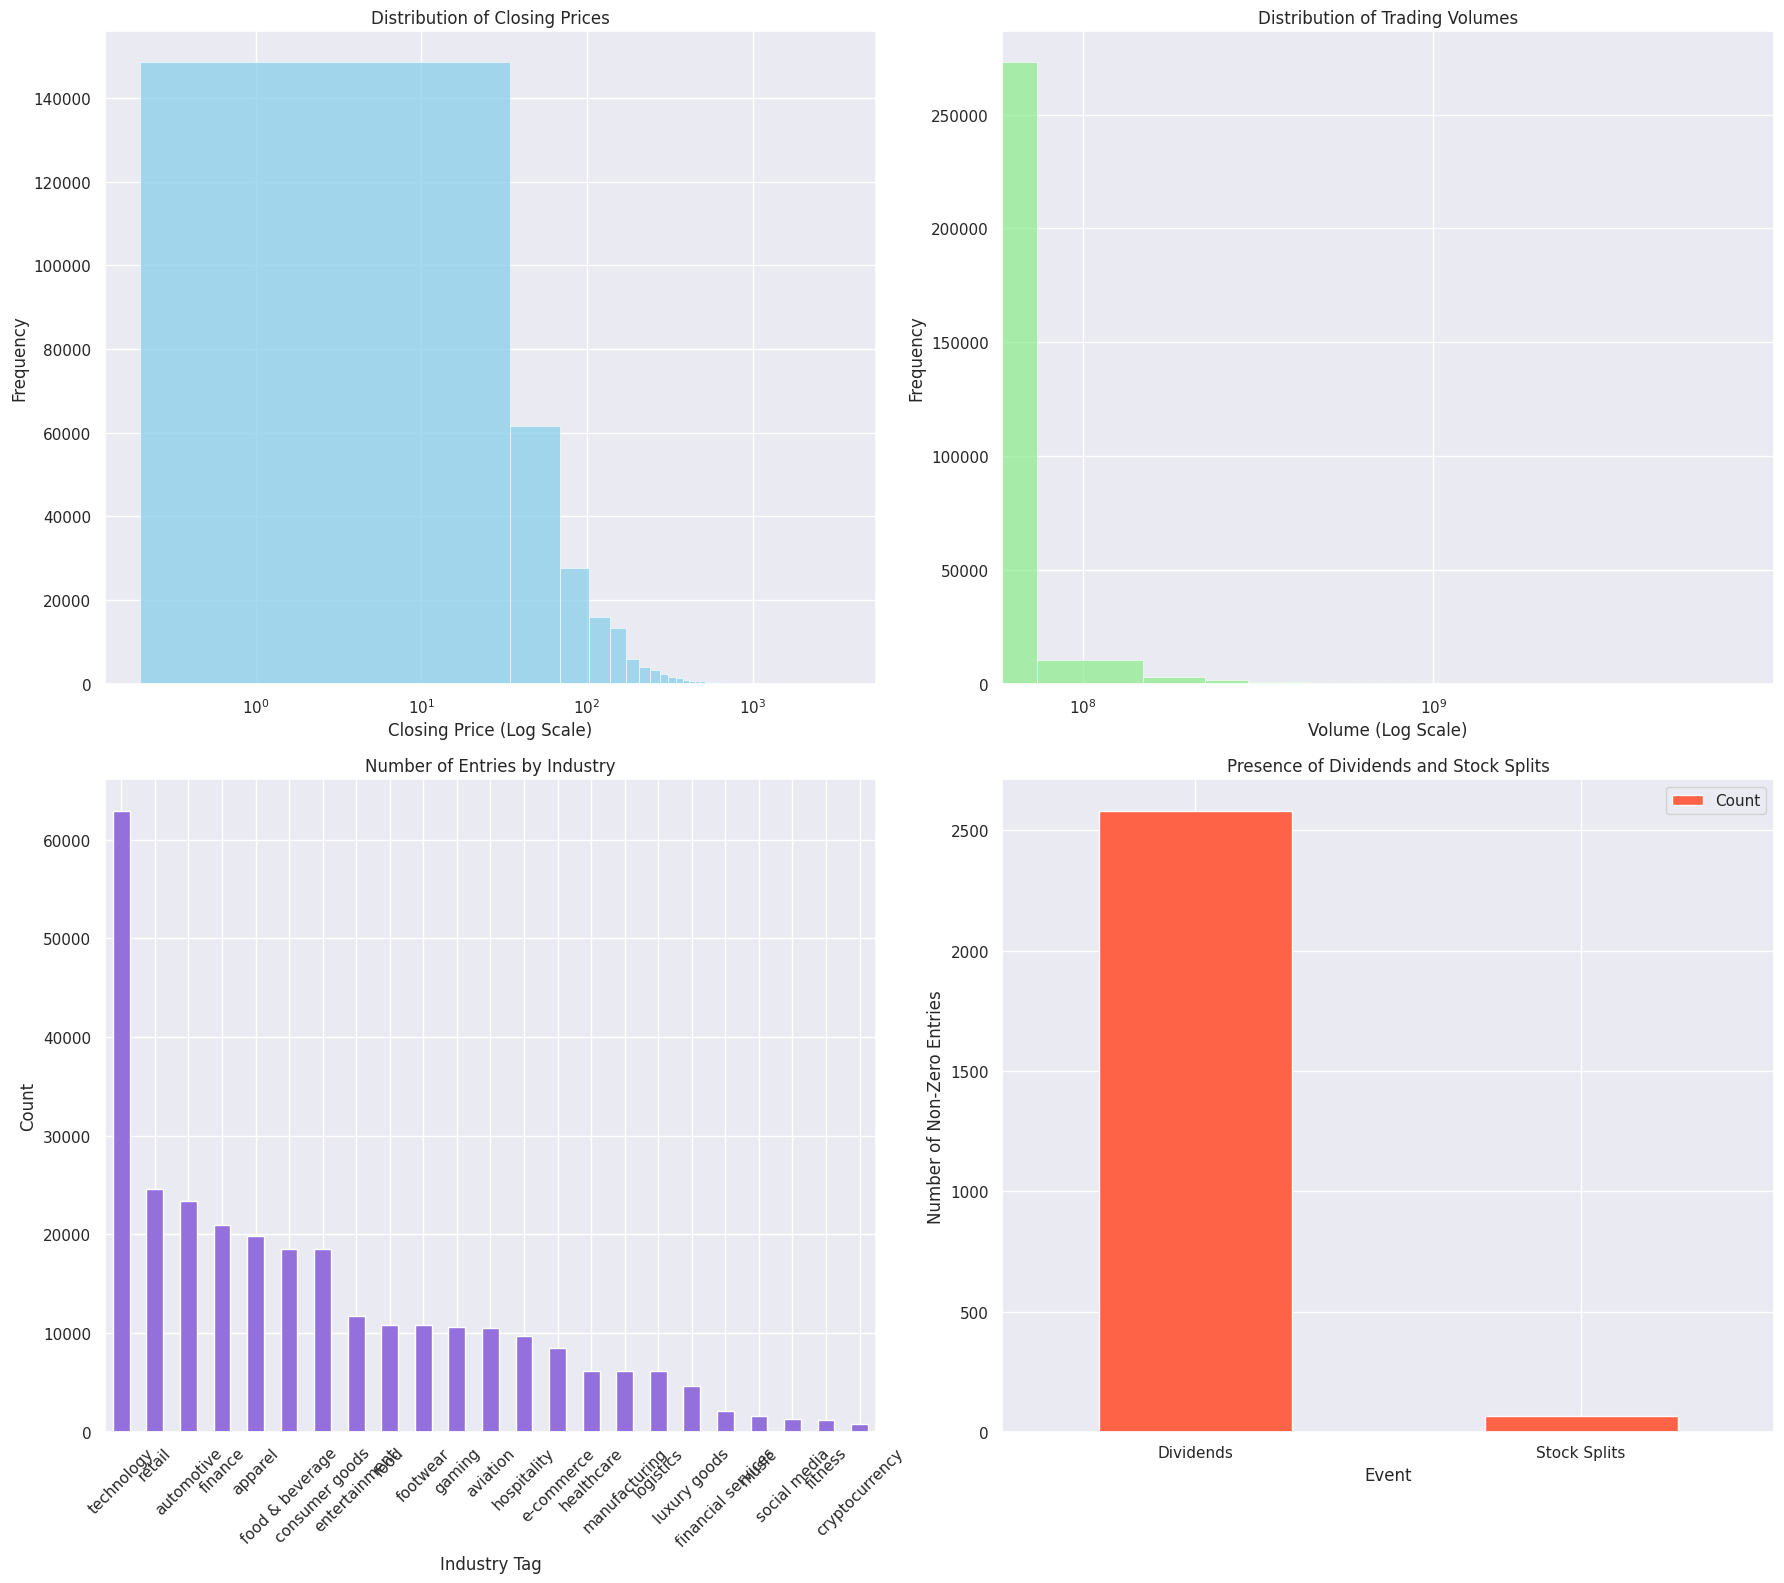

In [18]:
# Preparing data for plotting
# Distribution of Closing Prices
closing_prices = df['Close']

# Distribution of Volumes
volumes = df['Volume']

# Dividends and Stock Splits
dividends = df['Dividends']
stock_splits = df['Stock Splits']

# Industry representation
industry_counts = df['Industry_Tag'].value_counts()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Distribution of Closing Prices
sns.histplot(closing_prices, bins=100, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Closing Prices')
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlabel('Closing Price (Log Scale)')
axes[0, 0].set_ylabel('Frequency')

# Distribution of Volumes
sns.histplot(volumes, bins=100, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Trading Volumes')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Volume (Log Scale)')
axes[0, 1].set_ylabel('Frequency')

# Industry Representation
industry_counts.plot(kind='bar', ax=axes[1, 0], color='mediumpurple')
axes[1, 0].set_title('Number of Entries by Industry')
axes[1, 0].set_xlabel('Industry Tag')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Dividends and Stock Splits Presence
dividends_non_zero = dividends[dividends > 0].count()
stock_splits_non_zero = stock_splits[stock_splits > 0].count()
presence_data = {'Event': ['Dividends', 'Stock Splits'], 'Count': [dividends_non_zero, stock_splits_non_zero]}

presence_df = pd.DataFrame(presence_data)
presence_df.plot(kind='bar', x='Event', y='Count', ax=axes[1, 1], color='tomato')
axes[1, 1].set_title('Presence of Dividends and Stock Splits')
axes[1, 1].set_ylabel('Number of Non-Zero Entries')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

1. Distribution of Closing Prices: This histogram shows the frequency distribution of closing prices on a logarithmic scale, highlighting the wide range of stock prices in the dataset. The log scale helps to better visualize the distribution across a broad range of values.

2. Distribution of Trading Volumes: Similar to the closing prices, this histogram uses a logarithmic scale to display the trading volumes, illustrating the varied trading activity across different stocks. The log scale is crucial for managing the wide disparity in volumes.

3. Number of Entries by Industry: The bar chart presents the count of dataset entries categorized by industry, showcasing which sectors are more prevalent. This visualization helps identify the industries with the highest representation in the dataset.

4. Presence of Dividends and Stock Splits: This bar chart shows the number of non-zero entries for dividends and stock splits, offering insight into how often these events occur within the dataset. It highlights the relative rarity of dividends and stock splits compared to the total number of entries.

### Feature Engineering
As we learn about feature engineering and enriching data current columns and web scraping, we decided to evaluate which companies are in the *current* S&P 500 index fund. The source used to scrape is Wikipedia.

In [19]:
# Get a list of companies in the S&P 500 index
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id='constituents')

company_names = []
for row in table.find_all('tr')[1:]:  # Skip header row
    cells = row.find_all('td')
    company_names.append(cells[0].text.strip().lower())

In [20]:
# Add them to the dataframe
df['SP500'] = df['Ticker'].apply(lambda x: x in company_names)

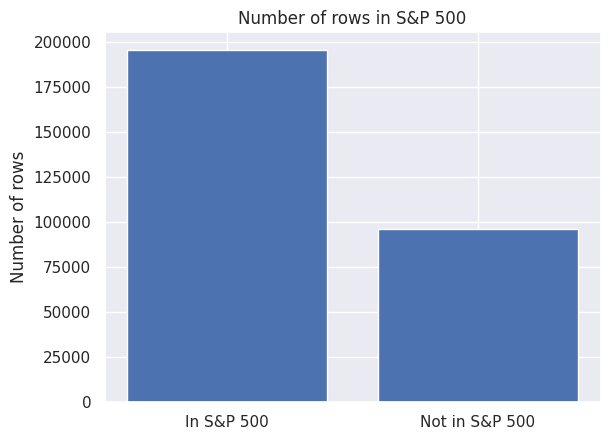

In [21]:
# Plot bars
plt.bar(['In S&P 500', 'Not in S&P 500'], [df['SP500'].value_counts()[True], df['SP500'].value_counts()[False]], label='Count')

# Set labels and title
plt.ylabel('Number of rows')
plt.title('Number of rows in S&P 500')

# Show plot
plt.show()

## DataFrame

In [22]:
sp500_df = df.loc[df['SP500'] ==True][['Date', 'Open', 'Close', 'Ticker']].sort_values(by = ['Date', 'Ticker']).reset_index(drop=True)

In [26]:
sp500_df['Date'] = sp500_df['Date'].dt.date

In [28]:
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

In [29]:
sp500_df

,Date,Open,Close,Ticker
0,2000-01-03,0.794800,0.848323,aapl
1,2000-01-03,16.693566,16.274675,adbe
2,2000-01-03,14.968750,15.500000,amd
3,2000-01-03,4.075000,4.468750,amzn
4,2000-01-03,34.729481,33.198849,axp
...,...,...,...,...
195547,2024-06-21,182.190002,183.009995,tsla
195548,2024-06-21,70.040001,70.209999,uber
195549,2024-06-21,70.040001,70.209999,uber
195550,2024-06-21,277.170013,275.220001,v


In [57]:
# Extract month and year from 'Date' and create a new column 'mm/yyyy'
sp500_df['mm/yyyy'] = sp500_df['Date'].dt.strftime('%m/%Y')

# Group by 'mm/yyyy' and aggregate unique tickers
monthly_tickers = sp500_df.groupby('mm/yyyy')['Ticker'].unique().reset_index()

# Convert the 'Ticker' column values to list of tickers
monthly_tickers['Ticker'] = monthly_tickers['Ticker'].apply(list)

In [58]:
# Convert 'mm/yyyy' to datetime format for proper sorting
monthly_tickers['mm/yyyy'] = pd.to_datetime(monthly_tickers['mm/yyyy'], format='%m/%Y')

# Sort the dataframe by the 'mm/yyyy' column
monthly_tickers_sorted = monthly_tickers.sort_values(by='mm/yyyy').reset_index(drop=True)

# Convert 'mm/yyyy' back to string format
monthly_tickers_sorted['mm/yyyy'] = monthly_tickers_sorted['mm/yyyy'].dt.strftime('%m/%Y')

monthly_tickers_sorted

,mm/yyyy,Ticker
0,01/2000,"[aapl, adbe, amd, amzn, axp, cl, cost, csco, d..."
1,02/2000,"[aapl, adbe, amd, amzn, axp, cl, cost, csco, d..."
2,03/2000,"[aapl, adbe, amd, amzn, axp, cl, cost, csco, d..."
3,04/2000,"[aapl, adbe, amd, amzn, axp, cl, cost, csco, d..."
4,05/2000,"[aapl, adbe, amd, amzn, axp, cl, cost, csco, d..."
...,...,...
289,02/2024,"[aapl, abnb, adbe, amd, amzn, axp, cl, cmg, co..."
290,03/2024,"[aapl, abnb, adbe, amd, amzn, axp, cl, cmg, co..."
291,04/2024,"[aapl, abnb, adbe, amd, amzn, axp, cl, cmg, co..."
292,05/2024,"[aapl, abnb, adbe, amd, amzn, axp, cl, cmg, co..."


Companies file:

In [61]:
# Create a dictionary to hold the data for the new dataframe
data_dict = {}

# Populate the dictionary with month/year as keys and lists of tickers as values
for index, row in monthly_tickers_sorted.iterrows():
    data_dict[row['mm/yyyy']] = row['Ticker']

for key in data_dict.keys():
    data_dict[key].sort()

# Find the maximum length of the ticker lists
max_length = max(len(tickers) for tickers in data_dict.values())

# Create a new dataframe with 'mm/yyyy' as columns and fill with ticker values
reformatted_df = pd.DataFrame({key: pd.Series(value) for key, value in data_dict.items()})

# Write the reformatted dataframe to a CSV file
csv_file_path_reformatted = '/content/SPXconst.csv'
reformatted_df.to_csv(csv_file_path_reformatted, index=False)

csv_file_path_reformatted

'/content/SPXconst.csv'

Close and Open files:

In [70]:
!mkdir files

In [71]:
# Ensure that there are no duplicate entries by aggregating them
sp500_df = sp500_df.groupby(['Date', 'Ticker']).agg({'Open': 'mean', 'Close': 'mean'}).reset_index()

# Extract year from 'Date'
sp500_df['Year'] = sp500_df['Date'].dt.year

# List of unique years in the dataframe
unique_years = sp500_df['Year'].unique()

# Add the next three years' data to each file
for year in unique_years:
    if year > 2021:
        continue

    # Select data from the current year up to the next three years
    yearly_data = sp500_df[(sp500_df['Year'] >= year) & (sp500_df['Year'] <= year + 3)]

    # Pivot the data for 'Open' prices
    open_prices = yearly_data.pivot(index='Date', columns='Ticker', values='Open').reset_index()
    open_prices.to_csv(f'/content/files/Open-{year}.csv', index=False)

    # Pivot the data for 'Close' prices
    close_prices = yearly_data.pivot(index='Date', columns='Ticker', values='Close').reset_index()
    close_prices.to_csv(f'/content/files/Close-{year}.csv', index=False)

# List of files created for download
open_files_updated = [f'Open-{year}.csv' for year in unique_years if year <= 2021]
close_files_updated = [f'Close-{year}.csv' for year in unique_years if year <= 2021]

open_files_updated, close_files_updated
open_files, close_files

(['Open-2000.csv',
  'Open-2001.csv',
  'Open-2002.csv',
  'Open-2003.csv',
  'Open-2004.csv',
  'Open-2005.csv',
  'Open-2006.csv',
  'Open-2007.csv',
  'Open-2008.csv',
  'Open-2009.csv',
  'Open-2010.csv',
  'Open-2011.csv',
  'Open-2012.csv',
  'Open-2013.csv',
  'Open-2014.csv',
  'Open-2015.csv',
  'Open-2016.csv',
  'Open-2017.csv',
  'Open-2018.csv',
  'Open-2019.csv',
  'Open-2020.csv',
  'Open-2021.csv',
  'Open-2022.csv',
  'Open-2023.csv',
  'Open-2024.csv'],
 ['Close-2000.csv',
  'Close-2001.csv',
  'Close-2002.csv',
  'Close-2003.csv',
  'Close-2004.csv',
  'Close-2005.csv',
  'Close-2006.csv',
  'Close-2007.csv',
  'Close-2008.csv',
  'Close-2009.csv',
  'Close-2010.csv',
  'Close-2011.csv',
  'Close-2012.csv',
  'Close-2013.csv',
  'Close-2014.csv',
  'Close-2015.csv',
  'Close-2016.csv',
  'Close-2017.csv',
  'Close-2018.csv',
  'Close-2019.csv',
  'Close-2020.csv',
  'Close-2021.csv',
  'Close-2022.csv',
  'Close-2023.csv',
  'Close-2024.csv'])

In [72]:
import shutil
from google.colab import files

# Create a zip file of the folder
shutil.make_archive('/content/files', 'zip', '/content/files')

# Download the zip file
files.download('/content/files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>